# Visualizing and Calculating Mean Values

In [1]:
### Importing packages

# 1. Core

import io
import pickle
from copy import copy
from collections import OrderedDict
import requests
import pathlib
import glob, os
import itertools
import os.path as op

# 2. Data Science

import numpy as np
import pandas as pd
import scipy

# 3. Visualization

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from hypyp.ext.mpl3d import glm
from hypyp.ext.mpl3d.mesh import Mesh
from hypyp.ext.mpl3d.camera import Camera
from mne.viz import circular_layout
#import matplotlib
#matplotlib.use('Qt5Agg')

# 4. Brain Core

import mne
import mne_connectivity
from mne.datasets import eegbci
from mne.datasets import fetch_fsaverage
from mne.preprocessing import (ICA, corrmap)
from mne.beamformer import make_lcmv, apply_lcmv_epochs, apply_lcmv

import hypyp
from hypyp import prep 
from hypyp import analyses
from hypyp import stats
from hypyp import viz

# Sensor Space

## — PLV

In [4]:
### Defining functions for data presentations

def freq_fun(string):
    ff = ['theta','beta','alpha_combined','alpha_low','alpha_high']
    for f in ff:
        if f in string:
            result = f
    return(result)

def ref_fun(string):
    rr = ['ave','csd','rest']
    for r in rr:
        if r in string:
            result = r
    return(result)

def cond_fun(string):
    new_string = string.split('_vs_')
    cc = ['coupled','control','individual','lf','ao']
    for c in cc:
        if c in new_string[0]:
            cond1 = c
        if c in new_string[1]:
            cond2 = c
    return(cond1,cond2)

def clear_data_frame(results_dict):
    key_list = []
    n_list = []
    index_list = []
    sign_list = []

    freq_list = []
    cond1_list = []
    cond2_list = []
    ref_list = []
    dict_for_plots_plv = {}

    for key in results_dict.keys():
    
        clusters = results_dict[key][1]
        cluster_p_values = results_dict[key][2]
        Stat_obs = results_dict[key][0]
    
        n_significant_clusters = len([i for i in cluster_p_values if i<0.05])
        if n_significant_clusters > 0:
            freq_list.append(freq_fun(key))
            ref_list.append(ref_fun(key))
            cond1_list.append(cond_fun(key)[0])
            cond2_list.append(cond_fun(key)[1])
        
            cluster_indices = [list(cluster_p_values).index(i) for i in cluster_p_values if i<0.05]
            key_list.append(key)
            n_list.append(n_significant_clusters)
            index_list.append(cluster_indices)
        
            sign_sublist = []
            for cluster_p in cluster_p_values:
                if cluster_p <= 0.05:
                    sensors_plot = clusters[np.where(cluster_p_values == cluster_p)[0][0]].astype('uint8')
                    Stat_values = sensors_plot*Stat_obs
                    dict_for_plots_plv[key] = Stat_values
                
                    cluster_values = []
                    for e_out in range(0,64):
                        for e_in in range(0,64):
                            if Stat_values[e_out][e_in] != 0:
                                cluster_values.append(Stat_values[e_out][e_in])
            
                    if sum(np.sign(cluster_values)) != len(np.sign(cluster_values)):
                        sign_sublist.append('negative')
                    else:
                        sign_sublist.append('positive')
            sign_list.append(sign_sublist)
                
    cluster_data_df = pd.DataFrame({
        'Key':key_list,
        'Condition_1': cond1_list,
        'Condition_2': cond2_list,
        'Frequency': freq_list,
        'Reference': ref_list,
        'N_signif._clusters': n_list,
        'Signs': sign_list,
        'Indices': index_list
    })
    
    return(cluster_data_df,dict_for_plots_plv)

In [5]:
### Loading PLV data
folder1 = "/Users/aliaksandrdabranau/Data/Mirror_game/"

with open(folder1+'plv_results_permutation.pickle', 'rb') as a:
    plv_res_perm = pickle.load(a)

In [6]:
### Loading Ccorr data
folder1 = "/Users/aliaksandrdabranau/Data/Mirror_game/"

with open(folder1+'ccorr_results_permutation_1.pickle', 'rb') as a:
    ccorr_res_perm = pickle.load(a)

csd_beta_lf_vs_control


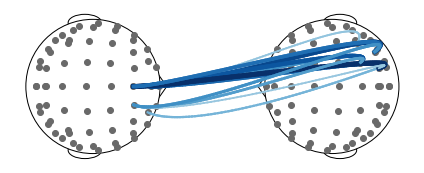

csd_beta_coupled_vs_control


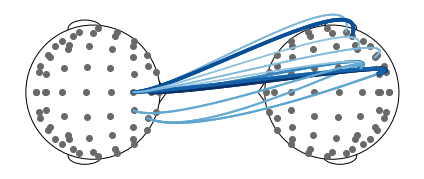

In [10]:
### Visualizing PLV

pair_n = '005'
folder = f"/Users/aliaksandrdabranau/Data/Mirror_game/pair{pair_n}"

condition = 'coupled'

keys_to_plot = ['csd_beta_lf_vs_control',
                'csd_beta_coupled_vs_control']

epochs_a = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}a_ave_epo.fif'), verbose=False)
epochs_b = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}b_ave_epo.fif'), verbose=False)

for key in keys_to_plot:
    print(key)
    viz.viz_2D_topomap_inter(epochs_a.pick(picks='data'), epochs_b.pick(picks='data'), 
                             clear_data_frame(plv_res_perm)[1][key], 
                             threshold=1, steps=100, lab=False)

plt.show()

csd_beta_lf_vs_control


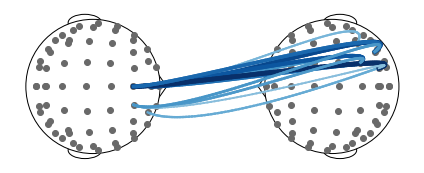

csd_beta_coupled_vs_control


KeyError: 'csd_beta_coupled_vs_control'

In [8]:
### Visualizing Ccorr

keys_to_plot = ['csd_beta_lf_vs_control',
                'csd_beta_coupled_vs_control']


epochs_a = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}a_csd_epo.fif'), verbose=False)
epochs_b = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}b_csd_epo.fif'), verbose=False)

for key in keys_to_plot:
    print(key)
    viz.viz_2D_topomap_inter(epochs_a.pick(picks='data'), epochs_b.pick(picks='data'), 
                             clear_data_frame(ccorr_res_perm)[1][key], 
                             threshold=1, steps=100, lab=False)

plt.show()

## Checking Values

In [25]:
### Checking mean synchrony values in the significant clusters

### Loading the dictionary with symmetric conditions
folder1 = "/Users/aliaksandrdabranau/Data/Mirror_game/"
with open(folder1+'plv_symmetrical_conditions.pickle', 'rb') as s:
    plv_data_symmetric = pickle.load(s)
    
### Loading the dictionary with Asymmetric conditions 

with open(folder1+'plv_asymm_conditions_new.pickle', 'rb') as a:
    plv_data_asym = pickle.load(a)
    
### Merging two dicts

plv_data = plv_data_symmetric | plv_data_asym

In [132]:
### Loading CCORR

### Loading the dictionary with symmetric conditions

with open('ccorr_symmetric_conditions.pickle', 'rb') as s:
    ccorr_data_symmetric = pickle.load(s)
    
### Loading the dictionary with symmetric conditions (the rest)

with open('ccorr_symmetric_conditions_1.pickle', 'rb') as s:
    ccorr_data_symmetric_1 = pickle.load(s)
    
### Loading the dictionary with Asymmetric conditions 

with open('ccorr_asymm_conditions.pickle', 'rb') as a:
    ccorr_data_asym = pickle.load(a)
    
### Loading the dictionary with Asymmetric conditions 

with open('ccorr_asymm_conditions_1.pickle', 'rb') as a:
    ccorr_data_asym_1 = pickle.load(a)
    
### Merging two dicts

ccorr_data = ccorr_data_symmetric | ccorr_data_symmetric_1 | ccorr_data_asym | ccorr_data_asym_1

with open(folder1+'ccorr_results_permutation_1.pickle', 'rb') as k:
    ccorr_res_perm_1 = pickle.load(k)
with open(folder1+'ccorr_results_permutation.pickle', 'rb') as k:
    ccorr_res_perm_0 = pickle.load(k)
ccorr_res_perm = ccorr_res_perm_1 | ccorr_res_perm_0

In [119]:
### Getting signicicant connections

def significant_edges(dict_with_permutation_results, condition):

    data = abs(clear_data_frame(dict_with_permutation_results)[1][condition])

    signif_edges = []

    for e_out in range(0,64):
        for e_in in range(0,64):
            if data[e_out][e_in] != 0.0:
                signif_edges.append((e_out,e_in))
    return(signif_edges)

def return_mean(dict_with_sync_values, condition, signif_edges):
    
    ### Collecting all data files

    data_lf = [i for (x,i) in dict_with_sync_values.items() if condition in x]

    ### Collecting all values

    plv_lf = []

    for file in data_lf:
        for edge in signif_edges:
            plv_lf.append(file[edge[0]][edge[1]])

    return(np.mean(plv_lf), np.std(plv_lf))

In [127]:
print("— PLV —")
print("— AVE & REST —")
print('1. Following vs Control (Theta, AVE)')
print('Following = ',

        return_mean(plv_data,
                    '_ave_leader-follower_theta',
                    significant_edges(plv_res_perm,'ave_theta_lf_vs_control')))

print('Control = ',

        return_mean(plv_data,
                    '_ave_control_theta',
                    significant_edges(plv_res_perm,'ave_theta_lf_vs_control')))



print('\n2. Following vs Control (Theta, REST)')
print('Following = ',

        return_mean(plv_data,
                    '_rest_leader-follower_theta',
                    significant_edges(plv_res_perm,'rest_theta_lf_vs_control')))

print('Control = ',

        return_mean(plv_data,
                    '_rest_control_theta',
                    significant_edges(plv_res_perm,'rest_theta_lf_vs_control')))


print('\n3. Following vs Individual (Theta, REST)')
print('Following = ',

        return_mean(plv_data,
                    '_rest_leader-follower_theta',
                    significant_edges(plv_res_perm,'rest_theta_lf_vs_individual')))

print('Individual = ',

        return_mean(plv_data,
                    '_rest_individual_theta',
                    significant_edges(plv_res_perm,'rest_theta_lf_vs_individual')))


print('\n4. Following vs Individual (Alpha, AVE)')
print('Following = ',

        return_mean(plv_data,
                    '_ave_leader-follower_alpha_combined',
                    significant_edges(plv_res_perm,'ave_alpha_combined_lf_vs_individual')))

print('Individual = ',

        return_mean(plv_data,
                    '_ave_individual_alpha_combined',
                    significant_edges(plv_res_perm,'ave_alpha_combined_lf_vs_individual')))

print('\n5. Following vs Coupled (Alpha, AVE)')
print('Following = ',

        return_mean(plv_data,
                    '_ave_leader-follower_alpha_combined',
                    significant_edges(plv_res_perm,'ave_alpha_combined_lf_vs_coupled')))

print('Coupled = ',

        return_mean(plv_data,
                    '_ave_coupled_alpha_combined',
                    significant_edges(plv_res_perm,'ave_alpha_combined_lf_vs_coupled')))


print('\n6. Following vs Coupled (Alpha, REST)')
print('Following = ',

        return_mean(plv_data,
                    '_rest_leader-follower_alpha_combined',
                    significant_edges(plv_res_perm,'rest_alpha_combined_lf_vs_coupled')))

print('Coupled = ',

        return_mean(plv_data,
                    '_rest_coupled_alpha_combined',
                    significant_edges(plv_res_perm,'rest_alpha_combined_lf_vs_coupled')))


print("\n— CSD —")
print('7. Following vs Control (Beta, CSD)')
print('Following = ',

        return_mean(plv_data,
                    '_csd_leader-follower_beta',
                    significant_edges(plv_res_perm,'csd_beta_lf_vs_control')))

print('Control = ',

        return_mean(plv_data,
                    '_csd_control_beta',
                    significant_edges(plv_res_perm,'csd_beta_lf_vs_control')))

print('\n8. Coupled vs Control (Beta, CSD)')
print('Coupled = ',

        return_mean(plv_data,
                    '_csd_coupled_beta',
                    significant_edges(plv_res_perm,'csd_beta_coupled_vs_control')))

print('Control = ',

        return_mean(plv_data,
                    '_csd_control_beta',
                    significant_edges(plv_res_perm,'csd_beta_coupled_vs_control')))

— PLV —
— AVE & REST —
1. Following vs Control (Theta, AVE)
Following =  (0.20372760607860882, 0.008440847908733598)
Control =  (0.19639407271508752, 0.008869362957008655)

2. Following vs Control (Theta, REST)
Following =  (0.20289942794725832, 0.008488732085489604)
Control =  (0.1960910752584747, 0.009307737521326069)

3. Following vs Individual (Theta, REST)
Following =  (0.20322620797482732, 0.008889235176575251)
Individual =  (0.1953967502964536, 0.009964543007870752)

4. Following vs Individual (Alpha, AVE)
Following =  (0.16899751024269466, 0.008142136569531394)
Individual =  (0.17511002042496612, 0.008340378417053202)

5. Following vs Coupled (Alpha, AVE)
Following =  (0.16828095583947209, 0.007984122994934091)
Coupled =  (0.17479759497317213, 0.008857073738793984)

6. Following vs Coupled (Alpha, REST)
Following =  (0.16729274671075353, 0.0073479620556016105)
Coupled =  (0.17371411451676758, 0.008586487001988921)

— CSD —
7. Following vs Control (Beta, CSD)
Following =  (0.100

In [137]:
print("— CCORR —")
print("— AVE & REST —")
print('1. Following vs Control (Theta, AVE)')
print('Following = ',

        return_mean(ccorr_data,
                    '_ave_leader-follower_theta',
                    significant_edges(ccorr_res_perm,'ave_theta_lf_vs_control')))

print('Control = ',

        return_mean(ccorr_data,
                    '_ave_control_theta',
                    significant_edges(ccorr_res_perm,'ave_theta_lf_vs_control')))



print('\n2. Following vs Individual (Theta, AVE)')
print('Following = ',

        return_mean(ccorr_data,
                    '_ave_leader-follower_theta',
                    significant_edges(ccorr_res_perm,'ave_theta_lf_vs_individual')))

print('Individual = ',

        return_mean(ccorr_data,
                    '_ave_individual_theta',
                    significant_edges(ccorr_res_perm,'ave_theta_lf_vs_individual')))


print('\n3. Following vs Individual (Theta, REST)')
print('Following = ',

        return_mean(ccorr_data,
                    '_rest_leader-follower_theta',
                    significant_edges(ccorr_res_perm,'rest_theta_lf_vs_individual')))

print('Individual = ',

        return_mean(ccorr_data,
                    '_rest_individual_theta',
                    significant_edges(ccorr_res_perm,'rest_theta_lf_vs_individual')))


print('\n4. Following vs Individual (Alpha, AVE)')
print('Following = ',

        return_mean(ccorr_data,
                    '_ave_leader-follower_alpha_combined',
                    significant_edges(ccorr_res_perm,'ave_alpha_combined_lf_vs_individual')))

print('Individual = ',

        return_mean(ccorr_data,
                    '_ave_individual_alpha_combined',
                    significant_edges(ccorr_res_perm,'ave_alpha_combined_lf_vs_individual')))

print('\n5. Following vs Individual (Alpha, REST)')
print('Following = ',

        return_mean(ccorr_data,
                    '_rest_leader-follower_alpha_combined',
                    significant_edges(ccorr_res_perm,'rest_alpha_combined_lf_vs_individual')))

print('Individual = ',

        return_mean(ccorr_data,
                    '_rest_individual_alpha_combined',
                    significant_edges(ccorr_res_perm,'rest_alpha_combined_lf_vs_individual')))

print('\n6. Following vs Coupled (Alpha, AVE)')
print('Following = ',

        return_mean(ccorr_data,
                    '_ave_leader-follower_alpha_combined',
                    significant_edges(ccorr_res_perm,'ave_alpha_combined_lf_vs_coupled')))

print('Coupled = ',

        return_mean(ccorr_data,
                    '_ave_coupled_alpha_combined',
                    significant_edges(ccorr_res_perm,'ave_alpha_combined_lf_vs_coupled')))


print('\n7. Following vs Coupled (Alpha, REST)')
print('Following = ',

        return_mean(ccorr_data,
                    '_rest_leader-follower_alpha_combined',
                    significant_edges(ccorr_res_perm,'rest_alpha_combined_lf_vs_coupled')))

print('Coupled = ',

        return_mean(ccorr_data,
                    '_rest_coupled_alpha_combined',
                    significant_edges(ccorr_res_perm,'rest_alpha_combined_lf_vs_coupled')))


print("\n— CSD —")
print('8. Following vs Control (Beta, CSD)')
print('Following = ',

        return_mean(ccorr_data,
                    '_csd_leader-follower_beta',
                    significant_edges(ccorr_res_perm,'csd_beta_lf_vs_control')))

print('Control = ',

        return_mean(ccorr_data,
                    '_csd_control_beta',
                    significant_edges(ccorr_res_perm,'csd_beta_lf_vs_control')))

— CCORR —
— AVE & REST —
1. Following vs Control (Theta, AVE)
Following =  (0.18206003916292238, 0.008429615296082712)
Control =  (0.174891829820007, 0.00875737385600815)

2. Following vs Individual (Theta, AVE)
Following =  (0.18235266960902227, 0.010403318066063148)
Individual =  (0.17486781186597578, 0.008937771083801591)

3. Following vs Individual (Theta, REST)
Following =  (0.18109157624297778, 0.009226016038614315)
Individual =  (0.1731966547438439, 0.0101611558563353)

4. Following vs Individual (Alpha, AVE)
Following =  (0.15795068372934865, 0.008221094669835196)
Individual =  (0.16462004908175307, 0.009282791930896582)

5. Following vs Individual (Alpha, REST)
Following =  (0.15670479158645487, 0.008102505584266496)
Individual =  (0.16402174499915304, 0.008853671434605548)

6. Following vs Coupled (Alpha, AVE)
Following =  (0.1570917719947746, 0.007850504980842547)
Coupled =  (0.16329039290504702, 0.008410177686365544)

7. Following vs Coupled (Alpha, REST)
Following =  (0.15

In [157]:
### Source

# 1. Loading dictionaries
folder1 = "/Users/aliaksandrdabranau/Data/Mirror_game/"
with open(folder1+'con_result_dict.pickle', 'rb') as s:
    data_symmetric = pickle.load(s)
    
### Loading the dictionary with Asymmetric conditions 

with open(folder1+'asym_con_result_dict.pickle', 'rb') as a:
    data_asym = pickle.load(a)
    
### Merging two dicts

source_data = data_symmetric | data_asym


# Opening the dictionary
folder1 = "/Users/aliaksandrdabranau/Data/Mirror_game/"
with open(folder1+'source_res_perm_sym.pickle',  'rb') as a:
        source_sym = pickle.load(a)
        
with open(folder1+'source_asym_permutation_result_dict.pickle',  'rb') as s:
        source_asym = pickle.load(s)

source_permutation = source_sym | source_asym

### Defining functions for data presentations

def freq_fun(string):
    ff = ['theta','beta','alpha_combined']
    for f in ff:
        if f in string:
            result = f
    return(result)

def cond_fun(string):
    new_string = string.split('_vs_')
    cc = ['coupled','control','individual','following','observation']
    for c in cc:
        if c in new_string[0]:
            cond1 = c
        if c in new_string[1]:
            cond2 = c
    return(cond1,cond2)


def clear_data_frame_source(results_dict):
    key_list = []
    n_list = []
    index_list = []
    sign_list = []
    
    ref_list = []
    freq_list = []
    cond1_list = []
    cond2_list = []

    dict_for_plots_plv = {}

    for key in results_dict.keys():
    
        clusters = results_dict[key][1]
        cluster_p_values = results_dict[key][2]
        Stat_obs = results_dict[key][0]
    
        n_significant_clusters = len([i for i in cluster_p_values if i<0.05])
        if n_significant_clusters > 0:
            freq_list.append(freq_fun(key))
            cond1_list.append(cond_fun(key)[0])
            cond2_list.append(cond_fun(key)[1])
        
            cluster_indices = [list(cluster_p_values).index(i) for i in cluster_p_values if i<0.05]
            key_list.append(key)
            n_list.append(n_significant_clusters)
            index_list.append(cluster_indices)
        
            sign_sublist = []
            for cluster_p in cluster_p_values:
                if cluster_p <= 0.05:
                    sensors_plot = clusters[np.where(cluster_p_values == cluster_p)[0][0]].astype('uint8')
                    Stat_values = sensors_plot*Stat_obs
                    dict_for_plots_plv[key] = Stat_values
                
                    cluster_values = []
                    for e_out in range(0,192):
                        for e_in in range(0,192):
                            if Stat_values[e_out][e_in] != 0:
                                cluster_values.append(Stat_values[e_out][e_in])
            
                    if sum(np.sign(cluster_values)) != len(np.sign(cluster_values)):
                        sign_sublist.append('negative')
                    else:
                        sign_sublist.append('positive')
            sign_list.append(sign_sublist)
                
    cluster_data_df = pd.DataFrame({
        'Key':key_list,
        
        'Condition_1': cond1_list,
        'Condition_2': cond2_list,
        'Frequency': freq_list,
        'N_signif._clusters': n_list,
        'Signs': sign_list,
        'Indices': index_list
    })
    
    return(cluster_data_df,dict_for_plots_plv)


### Getting signicicant connections

def significant_edges(dict_with_permutation_results, condition):

    data = abs(clear_data_frame_source(dict_with_permutation_results)[1][condition])

    signif_edges = []

    for e_out in range(0,192):
        for e_in in range(0,192):
            if data[e_out][e_in] != 0.0:
                signif_edges.append((e_out,e_in))
    return(signif_edges)

def return_mean(dict_with_sync_values, condition, signif_edges, freq):
    
    ### Collecting all data files

    data_lf = [i[freq][0:192,192:192*2] for (x,i) in dict_with_sync_values.items() if condition in x]

    ### Collecting all values

    plv_lf = []

    for file in data_lf:
        for edge in signif_edges:
            plv_lf.append(file[edge[0]][edge[1]])

    return(np.mean(plv_lf), np.std(plv_lf))

In [158]:
print("— PLV —")
print("— SOURCE —")
print('1. Control vs Coupled (Beta)')
print('Control = ',

        return_mean(source_data,
                    '_control',
                    significant_edges(source_permutation,'beta_coupled_vs_control'),2))

print('Coupled = ',

        return_mean(source_data,
                    '_coupled',
                    significant_edges(source_permutation,'beta_coupled_vs_control'),2))


print('\n2. Individual vs Coupled (Beta)')
print('Individual = ',

        return_mean(source_data,
                    '_individual',
                    significant_edges(source_permutation,'beta_coupled_vs_individual'),2))

print('Coupled = ',

        return_mean(source_data,
                    '_coupled',
                    significant_edges(source_permutation,'beta_coupled_vs_individual'),2))

print('\n3. Individual vs Following (Theta)')
print('Individual = ',

        return_mean(source_data,
                    '_individual',
                    significant_edges(source_permutation,'theta_following_vs_individual'),0))

print('Following = ',

        return_mean(source_data,
                    '_leader-follower',
                    significant_edges(source_permutation,'theta_following_vs_individual'),0))


print('\n4. Following vs Coupled (Beta)')
print('Following = ',

        return_mean(source_data,
                    '_leader-follower',
                    significant_edges(source_permutation,'beta_following_vs_coupled'),2))

print('Coupled = ',

        return_mean(source_data,
                    '_coupled',
                    significant_edges(source_permutation,'beta_following_vs_coupled'),2))

— PLV —
— SOURCE —
1. Control vs Coupled (Beta)
Control =  (0.1035465474125568, 0.005234798430768054)
Coupled =  (0.09991949734161334, 0.004740581172361638)

2. Individual vs Coupled (Beta)
Individual =  (0.10318755844111746, 0.004952132345221028)
Coupled =  (0.09921039654979816, 0.004525863360940677)

3. Individual vs Following (Theta)
Individual =  (0.20445434254624367, 0.009314459950527296)
Following =  (0.19667211067114945, 0.008518360109897762)

4. Following vs Coupled (Beta)
Following =  (0.10369600628818938, 0.0037964467949699004)
Coupled =  (0.09983687396704312, 0.004378324239270187)


## Source Space

In [2]:
# Opening the dictionary
folder1 = "/Users/aliaksandrdabranau/Data/Mirror_game/"
with open(folder1+'source_res_perm_sym.pickle',  'rb') as a:
        source_sym = pickle.load(a)
        
with open(folder1+'source_asym_permutation_result_dict.pickle',  'rb') as s:
        source_asym = pickle.load(s)

source_permutation = source_sym | source_asym

In [3]:
### Defining functions for data presentations

def freq_fun(string):
    ff = ['theta','beta','alpha_combined']
    for f in ff:
        if f in string:
            result = f
    return(result)

def cond_fun(string):
    new_string = string.split('_vs_')
    cc = ['coupled','control','individual','following','observation']
    for c in cc:
        if c in new_string[0]:
            cond1 = c
        if c in new_string[1]:
            cond2 = c
    return(cond1,cond2)


def clear_data_frame(results_dict):
    key_list = []
    n_list = []
    index_list = []
    sign_list = []
    
    ref_list = []
    freq_list = []
    cond1_list = []
    cond2_list = []

    dict_for_plots_plv = {}

    for key in results_dict.keys():
    
        clusters = results_dict[key][1]
        cluster_p_values = results_dict[key][2]
        Stat_obs = results_dict[key][0]
    
        n_significant_clusters = len([i for i in cluster_p_values if i<0.05])
        if n_significant_clusters > 0:
            freq_list.append(freq_fun(key))
            cond1_list.append(cond_fun(key)[0])
            cond2_list.append(cond_fun(key)[1])
        
            cluster_indices = [list(cluster_p_values).index(i) for i in cluster_p_values if i<0.05]
            key_list.append(key)
            n_list.append(n_significant_clusters)
            index_list.append(cluster_indices)
        
            sign_sublist = []
            for cluster_p in cluster_p_values:
                if cluster_p <= 0.05:
                    sensors_plot = clusters[np.where(cluster_p_values == cluster_p)[0][0]].astype('uint8')
                    Stat_values = sensors_plot*Stat_obs
                    dict_for_plots_plv[key] = Stat_values
                
                    cluster_values = []
                    for e_out in range(0,192):
                        for e_in in range(0,192):
                            if Stat_values[e_out][e_in] != 0:
                                cluster_values.append(Stat_values[e_out][e_in])
            
                    if sum(np.sign(cluster_values)) != len(np.sign(cluster_values)):
                        sign_sublist.append('negative')
                    else:
                        sign_sublist.append('positive')
            sign_list.append(sign_sublist)
                
    cluster_data_df = pd.DataFrame({
        'Key':key_list,
        
        'Condition_1': cond1_list,
        'Condition_2': cond2_list,
        'Frequency': freq_list,
        'N_signif._clusters': n_list,
        'Signs': sign_list,
        'Indices': index_list
    })
    
    return(cluster_data_df,dict_for_plots_plv)

In [5]:
pair_n = '003'
condition = 'coupled'
    
folder = f"/Users/aliaksandrdabranau/Data/Mirror_game/pair{pair_n}"
    
short_epochs_a = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}a_short_epo.fif'), verbose=False)
short_epochs_b = mne.read_epochs(pathlib.Path(folder+f'/{pair_n}b_short_epo.fif'), verbose=False)
    
filter_a = mne.beamformer.read_beamformer(pathlib.Path(folder+f'/{pair_n}_filters_a-lcmv.h5'))
filter_b = mne.beamformer.read_beamformer(pathlib.Path(folder+f'/{pair_n}_filters_b-lcmv.h5'))
        
# Extracting voxel time courses
stc_a = apply_lcmv_epochs(short_epochs_a[condition], filter_a, verbose=False)
stc_b = apply_lcmv_epochs(short_epochs_b[condition], filter_b, verbose=False)

In [19]:
sym_results[1].keys()

dict_keys(['beta_coupled_vs_control', 'beta_coupled_vs_individual', 'theta_following_vs_individual', 'alpha_combined_observation_vs_following', 'alpha_combined_observation_vs_control', 'alpha_combined_observation_vs_individual', 'beta_observation_vs_coupled', 'beta_following_vs_coupled'])

In [47]:
### Retrieving labels

sym_results = clear_data_frame(source_permutation)
atlas_path = "/Users/aliaksandrdabranau/mne_data/MNE-fsaverage-data/fsaverage/mri/aparc.a2009s+aseg.mgz"

xxx = sym_results[1]['beta_following_vs_coupled']
yyy = np.zeros((192,192), dtype = float)
targets = []
for i in range(0,192):
    if False in [k for k in xxx[i] == yyy[i]]:
        targets.append(i)

links = []
for target in targets:
    for i in range(0,192):
        if xxx[target][i] not in [0.0,-0.0]:
            links.append((target,i))
            
brain_a = np.unique([i[0] for i in links])
brain_b = np.unique([i[1] for i in links])

lables = mne.get_volume_labels_from_aseg(atlas_path)

labels_brain_a = [lables[i] for i in brain_a]
labels_brain_b = [lables[i] for i in brain_b]

In [48]:
labels_brain_a

['ctx_rh_S_orbital_lateral',
 'ctx_rh_S_orbital_med-olfact',
 'ctx_rh_S_orbital-H_Shaped']

In [50]:
labels_brain_b

['Right-Thalamus-Proper',
 'Right-Caudate',
 'Right-Putamen',
 'Right-Pallidum',
 'Right-Hippocampus',
 'Right-Amygdala',
 'Right-Accumbens-area',
 'Right-VentralDC',
 'Right-vessel',
 'Right-choroid-plexus']

In [7]:
### Loading pre-computed and/or standard files

# Download fsaverage files
folder1 = f"/Users/aliaksandrdabranau/Data/Mirror_game/"
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
trans_new = 'sample_new2-trans.fif' # But I adjusted electrode positions a bit
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

# Reading forward solution
fwd_fname = 'eeg_new_fwd.fif'
forward = mne.read_forward_solution(folder1+fwd_fname)
src = forward['src']

0 files missing from root.txt in /Users/aliaksandrdabranau/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/aliaksandrdabranau/mne_data/MNE-fsaverage-data/fsaverage
Reading forward solution from /Users/aliaksandrdabranau/Data/Mirror_game/eeg_new_fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (14629 sources, 64 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


In [32]:
# Extracting target labels

labels_data_brain_a = []
for name in labels_brain_a:
    just_one_label = stc_a[0].in_label(label = name, mri = atlas_path, src = src)
    labels_data_brain_a.append(just_one_label)
    
labels_data_brain_b = []
for name_b in labels_brain_b:
    just_one_label_b = stc_b[0].in_label(label = name_b, mri = atlas_path, src = src)
    labels_data_brain_b.append(just_one_label_b)


data_brain_a = np.concatenate(([i.to_data_frame().iloc[:,2:].to_numpy() for i in labels_data_brain_a]), axis=1)
data_brain_b = np.concatenate(([i.to_data_frame().iloc[:,2:].to_numpy() for i in labels_data_brain_b]), axis=1)


def flatten(l):
    return [item for sublist in l for item in sublist]

list_a = [list(i.to_data_frame().columns[2:]) for i in labels_data_brain_a]
vertices_a = [np.unique([int(k[4:]) for k in flatten(list_a)])]

list_b = [list(i.to_data_frame().columns[2:]) for i in labels_data_brain_b]
vertices_b = [np.unique([int(k[4:]) for k in flatten(list_b)])]

viz_a = mne.VolSourceEstimate(data_brain_a.transpose(), vertices_a, tmin = 0, tstep = 0.00390625, 
                              subject=None, verbose=None)

viz_b = mne.VolSourceEstimate(data_brain_b.transpose(), vertices_b, tmin = 0, tstep = 0.00390625, 
                              subject=None, verbose=None)

Reading atlas /Users/aliaksandrdabranau/mne_data/MNE-fsaverage-data/fsaverage/mri/aparc.a2009s+aseg.mgz
1/1 atlas regions had at least one vertex in the source space
Reading atlas /Users/aliaksandrdabranau/mne_data/MNE-fsaverage-data/fsaverage/mri/aparc.a2009s+aseg.mgz
1/1 atlas regions had at least one vertex in the source space
Reading atlas /Users/aliaksandrdabranau/mne_data/MNE-fsaverage-data/fsaverage/mri/aparc.a2009s+aseg.mgz
1/1 atlas regions had at least one vertex in the source space
Reading atlas /Users/aliaksandrdabranau/mne_data/MNE-fsaverage-data/fsaverage/mri/aparc.a2009s+aseg.mgz
1/1 atlas regions had at least one vertex in the source space
Reading atlas /Users/aliaksandrdabranau/mne_data/MNE-fsaverage-data/fsaverage/mri/aparc.a2009s+aseg.mgz
1/1 atlas regions had at least one vertex in the source space
Reading atlas /Users/aliaksandrdabranau/mne_data/MNE-fsaverage-data/fsaverage/mri/aparc.a2009s+aseg.mgz
1/1 atlas regions had at least one vertex in the source space
Read

In [37]:
### Visualizing brain A

src = forward['src']
lims = [0, 0.5, 1]
kwargs = dict(src=src, subject='fsaverage', subjects_dir=subjects_dir,
              initial_time=1.316, verbose=True)

brain = viz_a.plot_3d(
    clim=dict(kind='value', lims=lims), hemi='both', size=(800, 800), colorbar = False, alpha=0.5,
    views=['coronal'], volume_options=1, smoothing_steps=100, show_traces = False,
    # Could do this for a 3-panel figure:
    #view_layout='horizontal', views=['coronal', 'sagittal', 'axial'],
    brain_kwargs=dict(silhouette=True),
    **kwargs)

In [51]:
### Making a circular plot of connectivity

def make_circular_plot(data, title, n_links, save_fig):

    # 1. Prepating the matrix

    zeros = np.zeros((192*2,192*2))
    n_ch = 192
    zeros[n_ch:n_ch*2, 0:n_ch] = data
    zeros = abs(zeros)

    # 2. Retrieving label names

    labels_full = mne.get_volume_labels_from_aseg(atlas_path)
    label_colors = mne.get_volume_labels_from_aseg(atlas_path, return_colors=True)[1]
    label_colors = [i/255 for i in label_colors]
    for i in label_colors:
        i[-1] = 1

    # 3. calculating y-positions
    min_y_pos = -0.09689518955990642
    max_y_pos = 0.0612414830769078 

    dummy = (max_y_pos-min_y_pos)/192
    y_pos = []
    for i in range(1,193):
        y_pos.append(min_y_pos+i*dummy)


    # 4. Saving the plot order and create a circular layout
    labels_full_a = ["A-"+i for i in labels_full]
    labels_full_b = ["B-"+i for i in labels_full]
    
    node_order = list()
    node_order.extend(labels_full_a[::-1])  # reverse the order
    node_order.extend(labels_full_b)

    node_angles = circular_layout(labels_full_a+labels_full_b, node_order, start_pos=90,
                              group_boundaries=[0, 192])

    # Plotting the graph using node colors from the FreeSurfer parcellation. 
    # We only show the 300 strongest connections.
    fig, ax = plt.subplots(figsize=(25, 25), dpi=150, facecolor='black',
                       subplot_kw=dict(polar=True))
    mne_connectivity.viz.plot_connectivity_circle(zeros, labels_full+labels_full, n_lines = n_links,
                         node_angles=node_angles, node_colors=label_colors+label_colors, 
                                              vmin=2.09, padding = 3.2,
                         title=title, ax=ax)
    fig.tight_layout()
    
    if save_fig == True:
        fig.savefig(title+'.png', dpi=500)

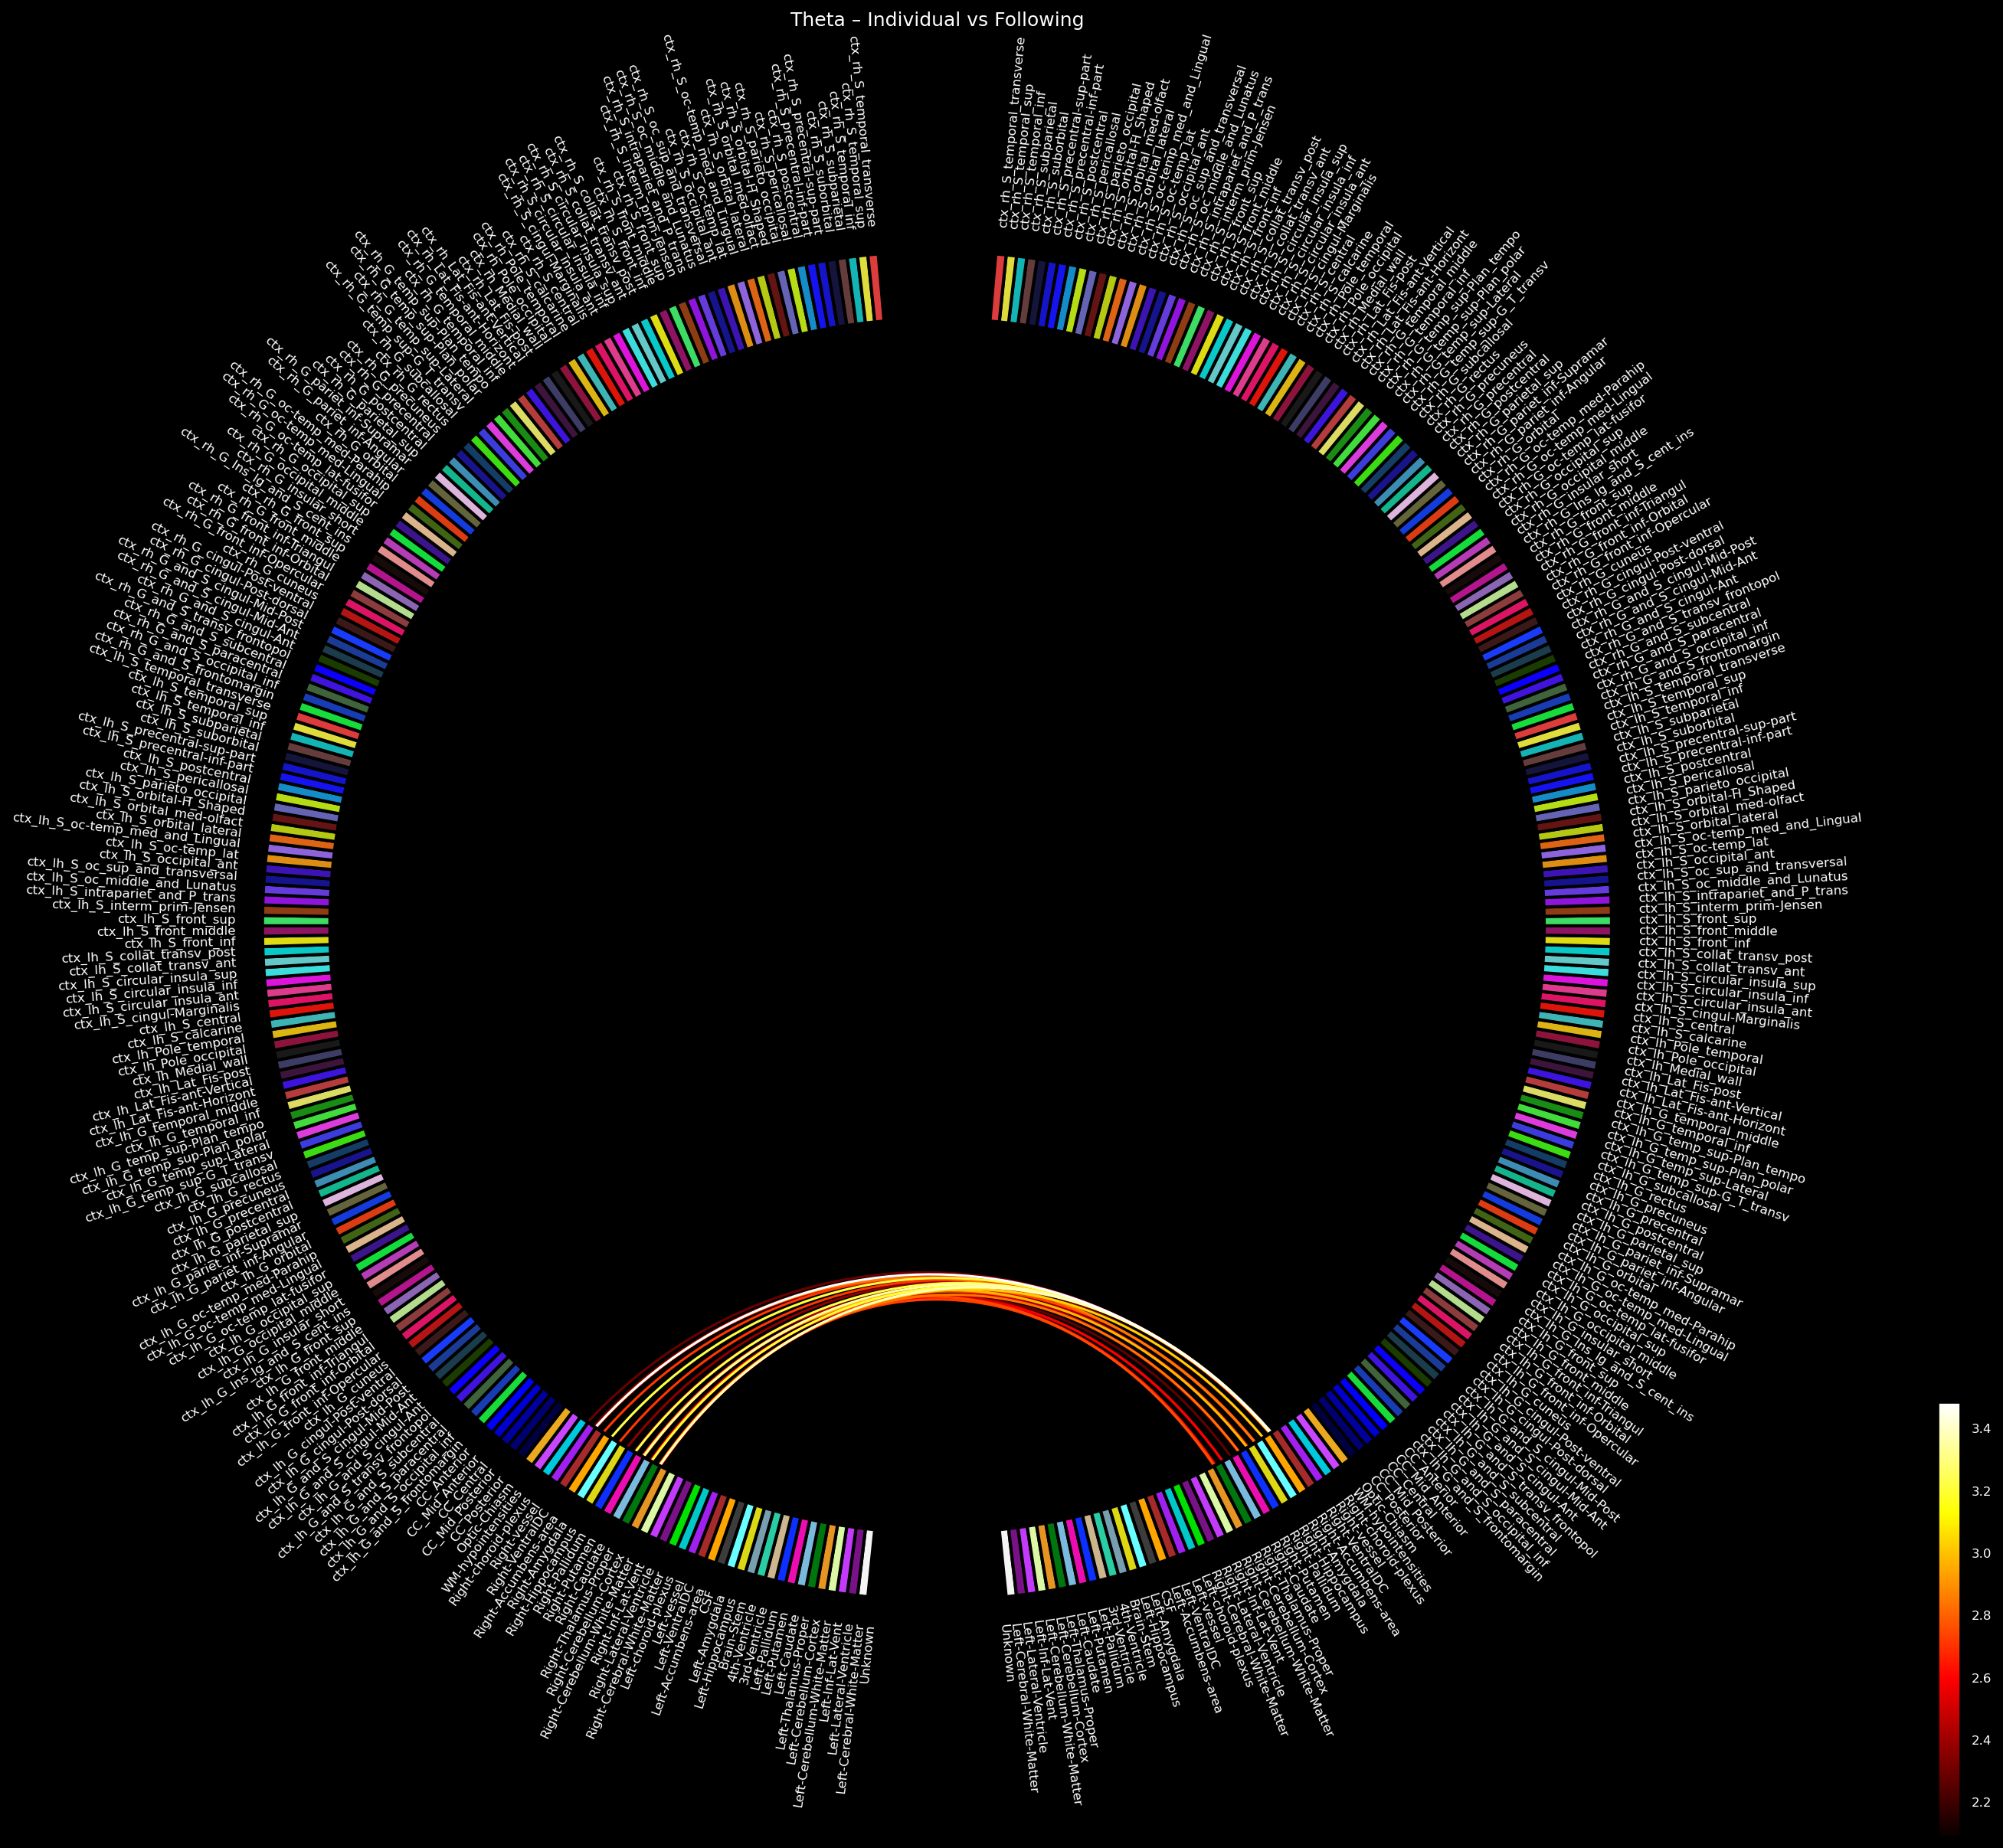

In [53]:
make_circular_plot(data = clear_data_frame(source_permutation)[1]['theta_following_vs_individual'],
                  title = 'Theta – Individual vs Following',
                  n_links = 30,
                  save_fig = True)